# Testing Model performance on CIFAR10 challenge according to different channel size
Channel Sizes tested: 
#### 5 Channel changes 
- 3 -> 16 -> 32 -> 64 -> 128
    Result: Accuracy on train set: 0.7472727272727273
            Accuracy on test set: 0.6269

#### 7 Channel chanes 
- 3 -> 16 -> 32 -> 64 -> 128 -> 256 -> 512
    Accuracy on train set: 0.7749090909090909
    Accuracy on test set: 0.6033

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import math

from Encoder_MultiheadedAttention import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2098039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.3352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].
Clipping input data to the valid 

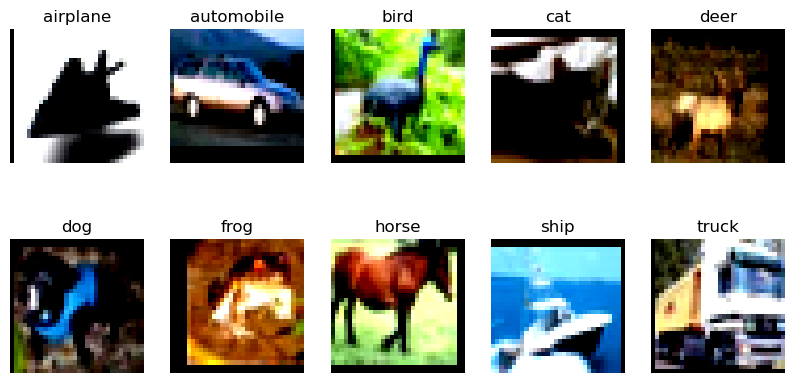

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
                                      ])
transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()

In [3]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #print("Output: ", outputs[12])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #print("Total: ", total)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_init = validate(model, testloader, device)
    print(f"Accuracy before Training: {acc_init}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader): 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = model(inputs)
            
            
            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [4]:
# Get the dimensions of the images from the dataset
image, label = trainset[0]
print(f"Image dimensions: {image.shape}")

Image dimensions: torch.Size([3, 32, 32])


#### 5 Channel Changes
- 3 -> 16 -> 32 -> 64 -> 128

In [ ]:
# Flatten the image tensor and calculate the dimensions for the Encoder
image_dim = 3072  # 3 * 32 * 32 = 3072
dim = image_dim  # Input dimension for the Encoder
head_size = 8  # Example head size
num_heads = 8  # Example number of heads

# Add a flattening step to the transformations
class FlattenTransform:
    def __call__(self, tensor):
        return tensor.view(-1)

transform_train.transforms.append(FlattenTransform())
transform_test.transforms.append(FlattenTransform())

# Initialize the Encoder model with the calculated dimensions
model = Encoder(dim=dim, head_size=head_size, num_heads=num_heads, ff_size=512, num_encoders=5, num_classes=10)

# Adjust the dimensions of the linear layers in the Encoder model
for layer in model.layers:
    for head in layer.mha.heads:
        head.K = nn.Linear(dim, head_size, bias=False)
        head.Q = nn.Linear(dim, head_size, bias=False)
        head.V = nn.Linear(dim, head_size, bias=False)
    layer.mha.Z = nn.Linear(num_heads * head_size, dim, bias=True)
    layer.ff[0] = nn.Linear(dim, 512, bias=True)
    layer.ff[2] = nn.Linear(512, dim, bias=True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
train(model, trainloader, testloader, criterion, optimizer, num_epochs=40, device=device)

Accuracy before Training: 0.0982


100%|██████████| 215/215 [02:45<00:00,  1.30it/s]

Epoch 1, loss: 2.191425041819728


Accuracy on train set: 0.1617818181818182
Accuracy on test set: 0.1027


100%|██████████| 215/215 [02:45<00:00,  1.30it/s]

Epoch 2, loss: 2.170310436293136


Accuracy on train set: 0.16498181818181817
Accuracy on test set: 0.0997


100%|██████████| 215/215 [02:45<00:00,  1.30it/s]

Epoch 3, loss: 2.1641722412996516


Accuracy on train set: 0.17025454545454546
Accuracy on test set: 0.0993


100%|██████████| 215/215 [02:45<00:00,  1.30it/s]

Epoch 4, loss: 2.161857898845229
